In [1]:
import os
import sys

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 70)
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, Reshape, Dense, Dropout, Concatenate, GRU, Conv2D, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import backend

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales = pd.read_csv('sales.csv', nrows=100)

float_cols = [c for c in sales if (sales[c].dtype == "float64")&('revenue' not in c)&('ratio' not in c)]
float16_cols = {c: np.float16 for c in float_cols}

int_cols = [c for c in sales if (sales[c].dtype == "int64")&(c != 'itemid')]
int8_cols = {c: np.int8 for c in int_cols}

float16_cols.update(int8_cols)
sales = pd.read_csv('sales.csv', engine='c', dtype=float16_cols)

In [3]:
sales = sales[sales.month>=12]

### First model : MLP + Embedding layers for categorical features

In [41]:
numerical_features = [
    'month',
    'tsitemid1',
    'tsitemid2',
    'tsitemid3',
    'tsitemid4',
    'tsitemid5',
    'tsitemid6',
    'tsitemid7',
    'tsitemid8',
    'tsitemid9',
    'tsitemid10',
    'tsitemid11',
    'tsitemid12',
    'tsshopid1',
    'tsshopid2',
    'tsshopid3',
    'tsshopid4',
    'tsshopid5',
    'tsshopid6',
    'tsshopid7',
    'tsshopid8',
    'tsshopid9',
    'tsshopid10',
    'tsshopid11',
    'tsshopid12',
    'tsshopcityid1',
    'tsshopcityid2',
    'tsshopcityid3',
    'tsshopcityid4',
    'tsshopcityid5',
    'tsshopcityid6',
    'tsshopcityid7',
    'tsshopcityid8',
    'tsshopcityid9',
    'tsshopcityid10',
    'tsshopcityid11',
    'tsshopcityid12',
    'tsshoptypeid1',
    'tsshoptypeid2',
    'tsshoptypeid3',
    'tsshoptypeid4',
    'tsshoptypeid5',
    'tsshoptypeid6',
    'tsshoptypeid7',
    'tsshoptypeid8',
    'tsshoptypeid9',
    'tsshoptypeid10',
    'tsshoptypeid11',
    'tsshoptypeid12',
    'tsitemcategoryid1',
    'tsitemcategoryid2',
    'tsitemcategoryid3',
    'tsitemcategoryid4',
    'tsitemcategoryid5',
    'tsitemcategoryid6',
    'tsitemcategoryid7',
    'tsitemcategoryid8',
    'tsitemcategoryid9',
    'tsitemcategoryid10',
    'tsitemcategoryid11',
    'tsitemcategoryid12',
    'tsitemcategorytypeid1',
    'tsitemcategorytypeid2',
    'tsitemcategorytypeid3',
    'tsitemcategorytypeid4',
    'tsitemcategorytypeid5',
    'tsitemcategorytypeid6',
    'tsitemcategorytypeid7',
    'tsitemcategorytypeid8',
    'tsitemcategorytypeid9',
    'tsitemcategorytypeid10',
    'tsitemcategorytypeid11',
    'tsitemcategorytypeid12',
    'tsitemcategorysubtypeid1',
    'tsitemcategorysubtypeid2',
    'tsitemcategorysubtypeid3',
    'tsitemcategorysubtypeid4',
    'tsitemcategorysubtypeid5',
    'tsitemcategorysubtypeid6',
    'tsitemcategorysubtypeid7',
    'tsitemcategorysubtypeid8',
    'tsitemcategorysubtypeid9',
    'tsitemcategorysubtypeid10',
    'tsitemcategorysubtypeid11',
    'tsitemcategorysubtypeid12',
    'tsshopiditemid1',
    'tsshopiditemid2',
    'tsshopiditemid3',
    'tsshopiditemid4',
    'tsshopiditemid5',
    'tsshopiditemid6',
    'tsshopiditemid7',
    'tsshopiditemid8',
    'tsshopiditemid9',
    'tsshopiditemid10',
    'tsshopiditemid11',
    'tsshopiditemid12',
    'tsitemcategoryiditemcategorytypeid1',
    'tsitemcategoryiditemcategorytypeid2',
    'tsitemcategoryiditemcategorytypeid3',
    'tsitemcategoryiditemcategorytypeid4',
    'tsitemcategoryiditemcategorytypeid5',
    'tsitemcategoryiditemcategorytypeid6',
    'tsitemcategoryiditemcategorytypeid7',
    'tsitemcategoryiditemcategorytypeid8',
    'tsitemcategoryiditemcategorytypeid9',
    'tsitemcategoryiditemcategorytypeid10',
    'tsitemcategoryiditemcategorytypeid11',
    'tsitemcategoryiditemcategorytypeid12',
    'tsitemcategoryiditemcategorysubtypeid1',
    'tsitemcategoryiditemcategorysubtypeid2',
    'tsitemcategoryiditemcategorysubtypeid3',
    'tsitemcategoryiditemcategorysubtypeid4',
    'tsitemcategoryiditemcategorysubtypeid5',
    'tsitemcategoryiditemcategorysubtypeid6',
    'tsitemcategoryiditemcategorysubtypeid7',
    'tsitemcategoryiditemcategorysubtypeid8',
    'tsitemcategoryiditemcategorysubtypeid9',
    'tsitemcategoryiditemcategorysubtypeid10',
    'tsitemcategoryiditemcategorysubtypeid11',
    'tsitemcategoryiditemcategorysubtypeid12',
    'tsitemcategoryidshopcityid1',
    'tsitemcategoryidshopcityid2',
    'tsitemcategoryidshopcityid3',
    'tsitemcategoryidshopcityid4',
    'tsitemcategoryidshopcityid5',
    'tsitemcategoryidshopcityid6',
    'tsitemcategoryidshopcityid7',
    'tsitemcategoryidshopcityid8',
    'tsitemcategoryidshopcityid9',
    'tsitemcategoryidshopcityid10',
    'tsitemcategoryidshopcityid11',
    'tsitemcategoryidshopcityid12',
    'tsitemcategoryidshoptypeid1',
    'tsitemcategoryidshoptypeid2',
    'tsitemcategoryidshoptypeid3',
    'tsitemcategoryidshoptypeid4',
    'tsitemcategoryidshoptypeid5',
    'tsitemcategoryidshoptypeid6',
    'tsitemcategoryidshoptypeid7',
    'tsitemcategoryidshoptypeid8',
    'tsitemcategoryidshoptypeid9',
    'tsitemcategoryidshoptypeid10',
    'tsitemcategoryidshoptypeid11',
    'tsitemcategoryidshoptypeid12',
    'tsitemcategoryidshopid1',
    'tsitemcategoryidshopid2',
    'tsitemcategoryidshopid3',
    'tsitemcategoryidshopid4',
    'tsitemcategoryidshopid5',
    'tsitemcategoryidshopid6',
    'tsitemcategoryidshopid7',
    'tsitemcategoryidshopid8',
    'tsitemcategoryidshopid9',
    'tsitemcategoryidshopid10',
    'tsitemcategoryidshopid11',
    'tsitemcategoryidshopid12',
    'tsitemcategorytypeiditemcategorysubtypeid1',
    'tsitemcategorytypeiditemcategorysubtypeid2',
    'tsitemcategorytypeiditemcategorysubtypeid3',
    'tsitemcategorytypeiditemcategorysubtypeid4',
    'tsitemcategorytypeiditemcategorysubtypeid5',
    'tsitemcategorytypeiditemcategorysubtypeid6',
    'tsitemcategorytypeiditemcategorysubtypeid7',
    'tsitemcategorytypeiditemcategorysubtypeid8',
    'tsitemcategorytypeiditemcategorysubtypeid9',
    'tsitemcategorytypeiditemcategorysubtypeid10',
    'tsitemcategorytypeiditemcategorysubtypeid11',
    'tsitemcategorytypeiditemcategorysubtypeid12',
    'tsitemcategorytypeidshopcityid1',
    'tsitemcategorytypeidshopcityid2',
    'tsitemcategorytypeidshopcityid3',
    'tsitemcategorytypeidshopcityid4',
    'tsitemcategorytypeidshopcityid5',
    'tsitemcategorytypeidshopcityid6',
    'tsitemcategorytypeidshopcityid7',
    'tsitemcategorytypeidshopcityid8',
    'tsitemcategorytypeidshopcityid9',
    'tsitemcategorytypeidshopcityid10',
    'tsitemcategorytypeidshopcityid11',
    'tsitemcategorytypeidshopcityid12',
    'tsitemcategorytypeidshoptypeid1',
    'tsitemcategorytypeidshoptypeid2',
    'tsitemcategorytypeidshoptypeid3',
    'tsitemcategorytypeidshoptypeid4',
    'tsitemcategorytypeidshoptypeid5',
    'tsitemcategorytypeidshoptypeid6',
    'tsitemcategorytypeidshoptypeid7',
    'tsitemcategorytypeidshoptypeid8',
    'tsitemcategorytypeidshoptypeid9',
    'tsitemcategorytypeidshoptypeid10',
    'tsitemcategorytypeidshoptypeid11',
    'tsitemcategorytypeidshoptypeid12',
    'tsitemcategorytypeidshopid1',
    'tsitemcategorytypeidshopid2',
    'tsitemcategorytypeidshopid3',
    'tsitemcategorytypeidshopid4',
    'tsitemcategorytypeidshopid5',
    'tsitemcategorytypeidshopid6',
    'tsitemcategorytypeidshopid7',
    'tsitemcategorytypeidshopid8',
    'tsitemcategorytypeidshopid9',
    'tsitemcategorytypeidshopid10',
    'tsitemcategorytypeidshopid11',
    'tsitemcategorytypeidshopid12',
    'tsitemcategorysubtypeidshopcityid1',
    'tsitemcategorysubtypeidshopcityid2',
    'tsitemcategorysubtypeidshopcityid3',
    'tsitemcategorysubtypeidshopcityid4',
    'tsitemcategorysubtypeidshopcityid5',
    'tsitemcategorysubtypeidshopcityid6',
    'tsitemcategorysubtypeidshopcityid7',
    'tsitemcategorysubtypeidshopcityid8',
    'tsitemcategorysubtypeidshopcityid9',
    'tsitemcategorysubtypeidshopcityid10',
    'tsitemcategorysubtypeidshopcityid11',
    'tsitemcategorysubtypeidshopcityid12',
    'tsitemcategorysubtypeidshoptypeid1',
    'tsitemcategorysubtypeidshoptypeid2',
    'tsitemcategorysubtypeidshoptypeid3',
    'tsitemcategorysubtypeidshoptypeid4',
    'tsitemcategorysubtypeidshoptypeid5',
    'tsitemcategorysubtypeidshoptypeid6',
    'tsitemcategorysubtypeidshoptypeid7',
    'tsitemcategorysubtypeidshoptypeid8',
    'tsitemcategorysubtypeidshoptypeid9',
    'tsitemcategorysubtypeidshoptypeid10',
    'tsitemcategorysubtypeidshoptypeid11',
    'tsitemcategorysubtypeidshoptypeid12',
    'tsitemcategorysubtypeidshopid1',
    'tsitemcategorysubtypeidshopid2',
    'tsitemcategorysubtypeidshopid3',
    'tsitemcategorysubtypeidshopid4',
    'tsitemcategorysubtypeidshopid5',
    'tsitemcategorysubtypeidshopid6',
    'tsitemcategorysubtypeidshopid7',
    'tsitemcategorysubtypeidshopid8',
    'tsitemcategorysubtypeidshopid9',
    'tsitemcategorysubtypeidshopid10',
    'tsitemcategorysubtypeidshopid11',
    'tsitemcategorysubtypeidshopid12',
    'tsshopcityidshoptypeid1',
    'tsshopcityidshoptypeid2',
    'tsshopcityidshoptypeid3',
    'tsshopcityidshoptypeid4',
    'tsshopcityidshoptypeid5',
    'tsshopcityidshoptypeid6',
    'tsshopcityidshoptypeid7',
    'tsshopcityidshoptypeid8',
    'tsshopcityidshoptypeid9',
    'tsshopcityidshoptypeid10',
    'tsshopcityidshoptypeid11',
    'tsshopcityidshoptypeid12',
    'tsshopcityidshopid1',
    'tsshopcityidshopid2',
    'tsshopcityidshopid3',
    'tsshopcityidshopid4',
    'tsshopcityidshopid5',
    'tsshopcityidshopid6',
    'tsshopcityidshopid7',
    'tsshopcityidshopid8',
    'tsshopcityidshopid9',
    'tsshopcityidshopid10',
    'tsshopcityidshopid11',
    'tsshopcityidshopid12',
    'tsshoptypeidshopid1',
    'tsshoptypeidshopid2',
    'tsshoptypeidshopid3',
    'tsshoptypeidshopid4',
    'tsshoptypeidshopid5',
    'tsshoptypeidshopid6',
    'tsshoptypeidshopid7',
    'tsshoptypeidshopid8',
    'tsshoptypeidshopid9',
    'tsshoptypeidshopid10',
    'tsshoptypeidshopid11',
    'tsshoptypeidshopid12',
    'tstarget1',
    'tstarget2',
    'tstarget3',
    'tstarget4',
    'tstarget5',
    'tstarget6',
    'tstarget7',
    'tstarget8',
    'tstarget9',
    'tstarget10',
    'tstarget11',
    'tstarget12',
    'meanlagitemshop',
    'meanlagitem',
    'cumulativemeanitemshop',
    #'deprecateditemshop',
    #'deprecateditem',
    'nbdays',
    'year',
    'monthofyear',
    'nbweekends',
    'monthssinceitemlaunched',
    'newitem',
    'monthssinceshoplaunched',
    'newshop',
    'itemno6',
    'shopno6',
    'tsshopiditemidproj2',
    'tsshopiditemidproj3',
    'tsshopiditemidproj6',
    'tsshopiditemidproj12',
    'tsitemidproj2',
    'tsitemidproj3',
    'tsitemidproj6',
    'tsitemidproj12',
    'tsshopidproj2',
    'tsshopidproj3',
    'tsshopidproj6',
    'tsshopidproj12',
    'meantsshopiditemidproj',
    'meantsitemidproj',
    'meantsshopidproj',
    #'itempriceavg',
    #'itempricemin',
    #'itempricemax',
    #'price',
    #'lastitemprice',
    #'antelastitemprice',
    #'ratiolastanteprice',
    #'ratiolastavgprice',
    #'ratiolastminprice',
    #'ratiolastmaxprice',
    #'ratiominmaxprice',
    'tsrevenue1',
    'tsrevenue2',
    'tsrevenue3',
    'tsrevenue4',
    'tsrevenue5',
    'tsrevenue6',
    'tsrevenue7',
    'tsrevenue8',
    'tsrevenue9',
    'tsrevenue10',
    'tsrevenue11',
    'tsrevenue12',
    'ratiorevenue12'
]

In [ ]:
categorical_features = [
    'shopid',
    'itemcategoryid',
    'shopcityid',
    'shoptypeid',
    'itemcategorytypeid',
    'itemcategorysubtypeid',
]

In [69]:
#Scale numerical features using a Standard Scaler

In [70]:
scaler = StandardScaler()
scaler.fit(sales[numerical_features])

salesscaled = pd.DataFrame(data=scaler.transform(sales[numerical_features]),columns=numerical_features,dtype=np.float16)
salesscaled['target'] = sales['target'].values

In [71]:
#Add categorical features

In [ ]:
salesscaled['monthoriginal'] = sales['month'].values
salesscaled['monthoriginal'] = salesscaled['monthoriginal'].astype(np.int8)
salesscaled['shopidoriginal'] = sales['shopid'].values
salesscaled['shopidoriginal'] = salesscaled['shopidoriginal'].astype(np.int8)
salesscaled['itemidoriginal'] = sales['itemid'].values

for feature in categorical_features:
    salesscaled[feature] = sales[feature].values

In [ ]:
#Check if categorical features are ordinally encoded

In [ ]:
def consecutive_categorical_ids(feature):
    print(feature)
    max_id = np.max(salesscaled[feature].unique())
    len_id = len(salesscaled[feature].unique())
    if max_id == len_id - 1:
        print('OK')
    else:
        print('NOK, max: {}, len: {}'.format(max_id,len_id))

In [ ]:
for feature in categorical_features:
    encoder = LabelEncoder()
    salesscaled[feature] = encoder.fit_transform(salesscaled[feature])
    consecutive_categorical_ids(feature)

In [45]:
with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(salesscaled.head(2))

In [5]:
def embedding_size(input_dim):
    return min(15, (input_dim + 1) // 3)

In [78]:
#Model Architecture

In [65]:
shopidnb = salesscaled.shopid.nunique()
shoptypeidnb = salesscaled.shoptypeid.nunique()
shopcityidnb = salesscaled.shopcityid.nunique()
itemcategoryidnb = salesscaled.itemcategoryid.nunique()
itemcategorytypeidnb = salesscaled.itemcategorytypeid.nunique()
itemcategorysubtypeidnb = salesscaled.itemcategorysubtypeid.nunique()

In [96]:
numericalinputs = Input(shape=(len(numerical_features),))

shopidinputs = Input(shape=(1,))
shopidembedding = Embedding(
    output_dim=embedding_size(shopidnb),
    input_dim=shopidnb,
    input_length=1,
    embeddings_initializer='he_normal')(shopidinputs)#'uniform'
shopidembedding = Reshape((embedding_size(shopidnb),))(shopidembedding)

shoptypeidinputs = Input(shape=(1,))
shoptypeidembedding = Embedding(
    output_dim=embedding_size(shoptypeidnb),
    input_dim=shoptypeidnb,
    input_length=1,
    embeddings_initializer='he_normal')(shoptypeidinputs)
shoptypeidembedding = Reshape((embedding_size(shoptypeidnb),))(shoptypeidembedding)

shopcityididinputs = Input(shape=(1,))
shopcityidembedding = Embedding(
    output_dim=embedding_size(shopcityidnb),
    input_dim=shopcityidnb,
    input_length=1,
    embeddings_initializer='he_normal')(shopcityididinputs)
shopcityidembedding = Reshape((embedding_size(shopcityidnb),))(shopcityidembedding)

itemcategoryidinputs = Input(shape=(1,))
itemcategoryidembedding = Embedding(
    output_dim=embedding_size(itemcategoryidnb),
    input_dim=itemcategoryidnb,
    input_length=1,
    embeddings_initializer='he_normal')(itemcategoryidinputs)
itemcategoryidembedding = Reshape((embedding_size(itemcategoryidnb),))(itemcategoryidembedding)

itemcategorytypeidinputs = Input(shape=(1,))
itemcategorytypeidembedding = Embedding(
    output_dim=embedding_size(itemcategorytypeidnb),
    input_dim=itemcategorytypeidnb,
    input_length=1,
    embeddings_initializer='he_normal')(itemcategorytypeidinputs)
itemcategorytypeidembedding = Reshape((embedding_size(itemcategorytypeidnb),))(itemcategorytypeidembedding)

itemcategorysubtypeidinputs = Input(shape=(1,))
itemcategorysubtypeidembedding = Embedding(
    output_dim=embedding_size(itemcategorysubtypeidnb),
    input_dim=itemcategorysubtypeidnb,
    input_length=1,
    embeddings_initializer='he_normal')(itemcategorysubtypeidinputs)
itemcategorysubtypeidembedding = Reshape((embedding_size(itemcategorysubtypeidnb),))(itemcategorysubtypeidembedding)

concatenated_layer = Concatenate()([
    numericalinputs,
    shopidembedding,
    shoptypeidembedding,
    shopcityidembedding,
    itemcategoryidembedding,
    itemcategorytypeidembedding,
    itemcategorysubtypeidembedding
])
#drop0 = Dropout(0.5)(concatenated_layer)

dense1 = Dense(256,activation='elu',kernel_initializer='he_normal')(concatenated_layer)
#drop1 = Dropout(0.5)(dense1)

dense2 = Dense(256,activation='elu',kernel_initializer='he_normal')(dense1)
#drop2 = Dropout(0.5)(dense2)

dense3 = Dense(128,activation='elu',kernel_initializer='he_normal')(dense2)
#drop3 = Dropout(0.5)(dense3)


outs = Dense(1)(dense3)

model = Model(inputs=[
    numericalinputs,
    shopidinputs,
    shoptypeidinputs,
    shopcityididinputs,
    itemcategoryidinputs,
    itemcategorytypeidinputs,
    itemcategorysubtypeidinputs
],outputs=outs)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='mse')

In [97]:
#Fit Model

In [98]:
modelname = "model_dl.h5"
checkpoint_cb = ModelCheckpoint(modelname, save_best_only=True)

monthpred = 33
train = salesscaled[salesscaled.monthoriginal<monthpred]
test = salesscaled[salesscaled.monthoriginal==monthpred]

epochs = 10
batchsize = 512

history = model.fit([
    train[numerical_features].values.reshape(-1,len(numerical_features)),
    train['shopid'].values.reshape(-1,1),
    train['shoptypeid'].values.reshape(-1,1),
    train['shopcityid'].values.reshape(-1,1),
    train['itemcategoryid'].values.reshape(-1,1),
    train['itemcategorytypeid'].values.reshape(-1,1),
    train['itemcategorysubtypeid'].values.reshape(-1,1)
],[train['target'].values.reshape(-1,1)],epochs=epochs,verbose=1,batch_size=batchsize,callbacks=[checkpoint_cb],validation_data=([
    test[numerical_features].values.reshape(-1,len(numerical_features)),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1)
    ],[test['target'].values.reshape(-1,1)]))

Train on 6186922 samples, validate on 238172 samples
Epoch 1/10
6186922/6186922 [==============================] - 455s 74us/sample - loss: 1.1022 - val_loss: 0.9745
Epoch 2/10
6186922/6186922 [==============================] - 254s 41us/sample - loss: 1.0713 - val_loss: 0.9508
Epoch 3/10
6186922/6186922 [==============================] - 254s 41us/sample - loss: 1.3510 - val_loss: 0.9878
Epoch 4/10
6186922/6186922 [==============================] - 269s 43us/sample - loss: 12.6037 - val_loss: 0.9817
Epoch 5/10
6186922/6186922 [==============================] - 253s 41us/sample - loss: 7.3708 - val_loss: 0.9771
Epoch 6/10
6186922/6186922 [==============================] - 254s 41us/sample - loss: 35.7296 - val_loss: 0.9811
Epoch 7/10
6186922/6186922 [==============================] - 258s 42us/sample - loss: 13.2323 - val_loss: 0.9917
Epoch 8/10
6186922/6186922 [==============================] - 251s 41us/sample - loss: 26.2137 - val_loss: 1.0717
Epoch 9/10
4854784/6186922 [===========

W0401 17:56:02.836901 4636560832 callbacks.py:989] Can save best model only with val_loss available, skipping.


4855296/6186922 [======================>.......] - ETA: 54s - loss: 355.7765

KeyboardInterrupt: 

In [92]:
model = load_model(modelname) #rollback to best model
mse = model.evaluate([
    test[numerical_features].values.reshape(-1,len(numerical_features)),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1)
], [test['target'].values.reshape(-1,1)])
print(mse)
rmse = math.sqrt(mse)
print('total mse : {}'.format(mse))
print('total rmse : {}'.format(rmse))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.7506884217427345
total mse : 0.7506884217427345
total rmse : 0.8664227730979458


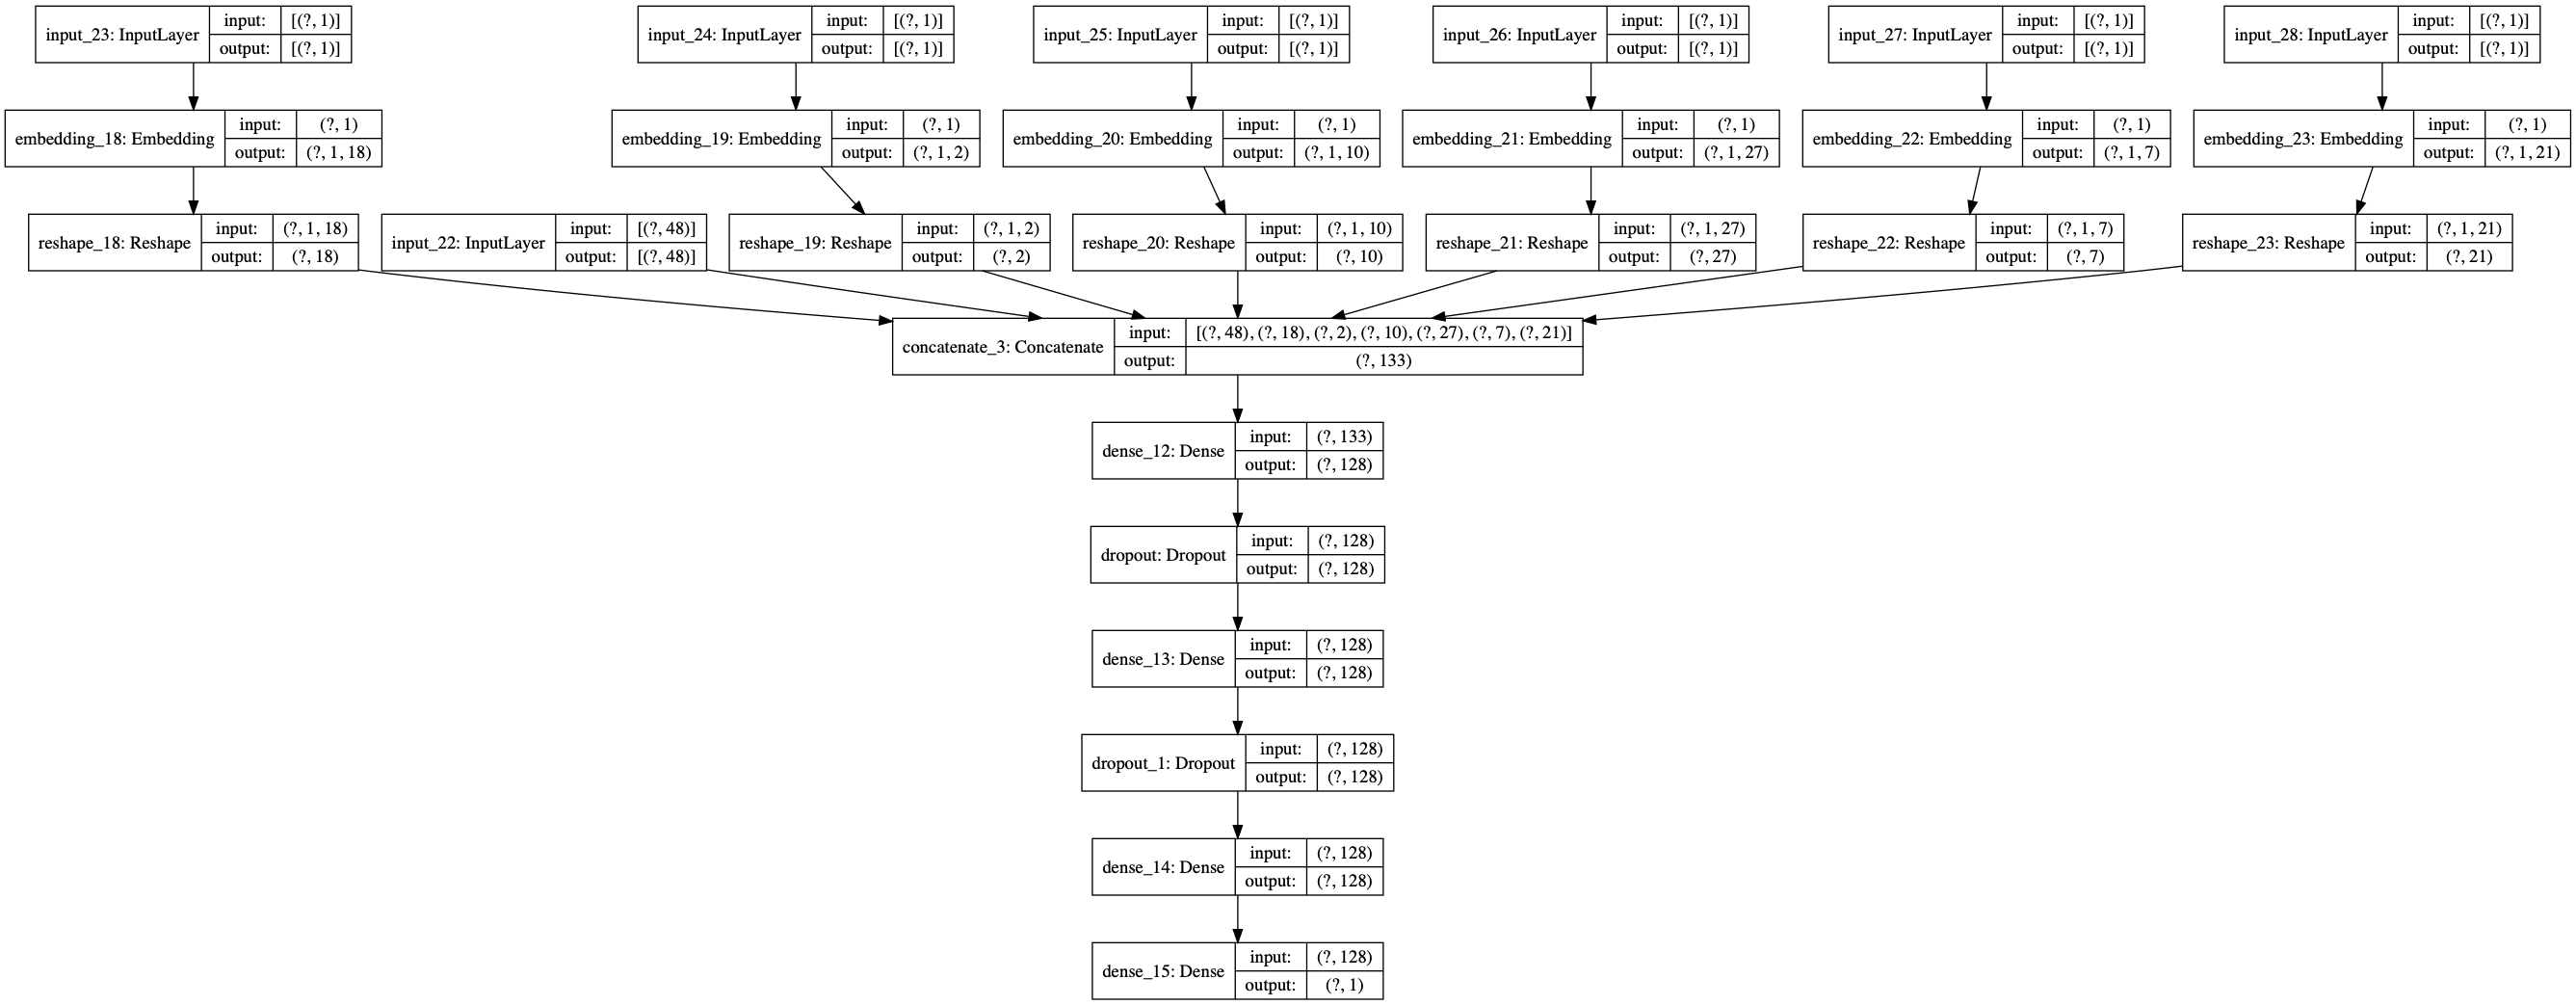

In [57]:
modelname = 'model_dl.h5'
model = load_model(modelname)
plot_model(model, 'model.png', show_shapes=True)

In [61]:
#Submission

In [94]:
test = pd.read_csv('./data/test.csv')
test.columns = ['ID','shopid','itemid']
test.loc[test.shopid == 0, 'shopid'] = 57
test.loc[test.shopid == 1, 'shopid'] = 58
test.loc[test.shopid == 10, 'shopid'] = 11
test.head(1)

,ID,shopid,itemid
0,0,5,5037


In [95]:
testdf = salesscaled[salesscaled.monthoriginal == 34]
preds = model.predict([
    testdf[numerical_features].values.reshape(-1,len(numerical_features)),
    testdf['shopid'].values.reshape(-1,1),
    testdf['shoptypeid'].values.reshape(-1,1),
    testdf['shopcityid'].values.reshape(-1,1),
    testdf['itemcategoryid'].values.reshape(-1,1),
    testdf['itemcategorytypeid'].values.reshape(-1,1),
    testdf['itemcategorysubtypeid'].values.reshape(-1,1)
])
testdf['item_cnt_month'] = preds
submission = pd.merge(test,testdf[['shopidoriginal','itemidoriginal','item_cnt_month']],left_on=['shopid','itemid'],right_on=['shopidoriginal','itemidoriginal'],how='left')
submission = submission[['ID','item_cnt_month']]
print(submission.shape)
print(submission['item_cnt_month'].min())
print(submission['item_cnt_month'].max())
submission['item_cnt_month'] = submission['item_cnt_month'].clip(0,20)
print(submission['item_cnt_month'].min())
print(submission['item_cnt_month'].max())

submission.to_csv('submission.csv',index=False)

(214200, 2)
-0.921538
20.412998
0.0
20.0


### Recurrent network (using GRU cells)

In [115]:
dictfeatures = {c: (int(c[-2:]) if (c[-2:][0]=='1') else int(c[-1:])) for c in numerical_features if ('ts' in c)&('proj' not in c)}

In [119]:
for item in sorted(dictfeatures.items(), key=lambda item: item[1],reverse=True):
    print(("'{}',").format(item[0]))

'tsitemid12',
'tsshopid12',
'tsshopcityid12',
'tsshoptypeid12',
'tsitemcategoryid12',
'tsitemcategorytypeid12',
'tsitemcategorysubtypeid12',
'tsshopiditemid12',
'tsitemcategoryiditemcategorytypeid12',
'tsitemcategoryiditemcategorysubtypeid12',
'tsitemcategoryidshopcityid12',
'tsitemcategoryidshoptypeid12',
'tsitemcategoryidshopid12',
'tsitemcategorytypeiditemcategorysubtypeid12',
'tsitemcategorytypeidshopcityid12',
'tsitemcategorytypeidshoptypeid12',
'tsitemcategorytypeidshopid12',
'tsitemcategorysubtypeidshopcityid12',
'tsitemcategorysubtypeidshoptypeid12',
'tsitemcategorysubtypeidshopid12',
'tsshopcityidshoptypeid12',
'tsshopcityidshopid12',
'tsshoptypeidshopid12',
'tstarget12',
'tsrevenue12',
'tsitemid11',
'tsshopid11',
'tsshopcityid11',
'tsshoptypeid11',
'tsitemcategoryid11',
'tsitemcategorytypeid11',
'tsitemcategorysubtypeid11',
'tsshopiditemid11',
'tsitemcategoryiditemcategorytypeid11',
'tsitemcategoryiditemcategorysubtypeid11',
'tsitemcategoryidshopcityid11',
'tsitemcategoryidsh

In [11]:
ts_features = [
    'tsitemid12',
    'tsshopid12',
    'tsshopcityid12',
    'tsshoptypeid12',
    'tsitemcategoryid12',
    'tsitemcategorytypeid12',
    'tsitemcategorysubtypeid12',
    'tsshopiditemid12',
    'tsitemcategoryiditemcategorytypeid12',
    'tsitemcategoryiditemcategorysubtypeid12',
    'tsitemcategoryidshopcityid12',
    'tsitemcategoryidshoptypeid12',
    'tsitemcategoryidshopid12',
    'tsitemcategorytypeiditemcategorysubtypeid12',
    'tsitemcategorytypeidshopcityid12',
    'tsitemcategorytypeidshoptypeid12',
    'tsitemcategorytypeidshopid12',
    'tsitemcategorysubtypeidshopcityid12',
    'tsitemcategorysubtypeidshoptypeid12',
    'tsitemcategorysubtypeidshopid12',
    'tsshopcityidshoptypeid12',
    'tsshopcityidshopid12',
    'tsshoptypeidshopid12',
    'tstarget12',
    'tsrevenue12',
    'tsitemid11',
    'tsshopid11',
    'tsshopcityid11',
    'tsshoptypeid11',
    'tsitemcategoryid11',
    'tsitemcategorytypeid11',
    'tsitemcategorysubtypeid11',
    'tsshopiditemid11',
    'tsitemcategoryiditemcategorytypeid11',
    'tsitemcategoryiditemcategorysubtypeid11',
    'tsitemcategoryidshopcityid11',
    'tsitemcategoryidshoptypeid11',
    'tsitemcategoryidshopid11',
    'tsitemcategorytypeiditemcategorysubtypeid11',
    'tsitemcategorytypeidshopcityid11',
    'tsitemcategorytypeidshoptypeid11',
    'tsitemcategorytypeidshopid11',
    'tsitemcategorysubtypeidshopcityid11',
    'tsitemcategorysubtypeidshoptypeid11',
    'tsitemcategorysubtypeidshopid11',
    'tsshopcityidshoptypeid11',
    'tsshopcityidshopid11',
    'tsshoptypeidshopid11',
    'tstarget11',
    'tsrevenue11',
    'tsitemid10',
    'tsshopid10',
    'tsshopcityid10',
    'tsshoptypeid10',
    'tsitemcategoryid10',
    'tsitemcategorytypeid10',
    'tsitemcategorysubtypeid10',
    'tsshopiditemid10',
    'tsitemcategoryiditemcategorytypeid10',
    'tsitemcategoryiditemcategorysubtypeid10',
    'tsitemcategoryidshopcityid10',
    'tsitemcategoryidshoptypeid10',
    'tsitemcategoryidshopid10',
    'tsitemcategorytypeiditemcategorysubtypeid10',
    'tsitemcategorytypeidshopcityid10',
    'tsitemcategorytypeidshoptypeid10',
    'tsitemcategorytypeidshopid10',
    'tsitemcategorysubtypeidshopcityid10',
    'tsitemcategorysubtypeidshoptypeid10',
    'tsitemcategorysubtypeidshopid10',
    'tsshopcityidshoptypeid10',
    'tsshopcityidshopid10',
    'tsshoptypeidshopid10',
    'tstarget10',
    'tsrevenue10',
    'tsitemid9',
    'tsshopid9',
    'tsshopcityid9',
    'tsshoptypeid9',
    'tsitemcategoryid9',
    'tsitemcategorytypeid9',
    'tsitemcategorysubtypeid9',
    'tsshopiditemid9',
    'tsitemcategoryiditemcategorytypeid9',
    'tsitemcategoryiditemcategorysubtypeid9',
    'tsitemcategoryidshopcityid9',
    'tsitemcategoryidshoptypeid9',
    'tsitemcategoryidshopid9',
    'tsitemcategorytypeiditemcategorysubtypeid9',
    'tsitemcategorytypeidshopcityid9',
    'tsitemcategorytypeidshoptypeid9',
    'tsitemcategorytypeidshopid9',
    'tsitemcategorysubtypeidshopcityid9',
    'tsitemcategorysubtypeidshoptypeid9',
    'tsitemcategorysubtypeidshopid9',
    'tsshopcityidshoptypeid9',
    'tsshopcityidshopid9',
    'tsshoptypeidshopid9',
    'tstarget9',
    'tsrevenue9',
    'tsitemid8',
    'tsshopid8',
    'tsshopcityid8',
    'tsshoptypeid8',
    'tsitemcategoryid8',
    'tsitemcategorytypeid8',
    'tsitemcategorysubtypeid8',
    'tsshopiditemid8',
    'tsitemcategoryiditemcategorytypeid8',
    'tsitemcategoryiditemcategorysubtypeid8',
    'tsitemcategoryidshopcityid8',
    'tsitemcategoryidshoptypeid8',
    'tsitemcategoryidshopid8',
    'tsitemcategorytypeiditemcategorysubtypeid8',
    'tsitemcategorytypeidshopcityid8',
    'tsitemcategorytypeidshoptypeid8',
    'tsitemcategorytypeidshopid8',
    'tsitemcategorysubtypeidshopcityid8',
    'tsitemcategorysubtypeidshoptypeid8',
    'tsitemcategorysubtypeidshopid8',
    'tsshopcityidshoptypeid8',
    'tsshopcityidshopid8',
    'tsshoptypeidshopid8',
    'tstarget8',
    'tsrevenue8',
    'tsitemid7',
    'tsshopid7',
    'tsshopcityid7',
    'tsshoptypeid7',
    'tsitemcategoryid7',
    'tsitemcategorytypeid7',
    'tsitemcategorysubtypeid7',
    'tsshopiditemid7',
    'tsitemcategoryiditemcategorytypeid7',
    'tsitemcategoryiditemcategorysubtypeid7',
    'tsitemcategoryidshopcityid7',
    'tsitemcategoryidshoptypeid7',
    'tsitemcategoryidshopid7',
    'tsitemcategorytypeiditemcategorysubtypeid7',
    'tsitemcategorytypeidshopcityid7',
    'tsitemcategorytypeidshoptypeid7',
    'tsitemcategorytypeidshopid7',
    'tsitemcategorysubtypeidshopcityid7',
    'tsitemcategorysubtypeidshoptypeid7',
    'tsitemcategorysubtypeidshopid7',
    'tsshopcityidshoptypeid7',
    'tsshopcityidshopid7',
    'tsshoptypeidshopid7',
    'tstarget7',
    'tsrevenue7',
    'tsitemid6',
    'tsshopid6',
    'tsshopcityid6',
    'tsshoptypeid6',
    'tsitemcategoryid6',
    'tsitemcategorytypeid6',
    'tsitemcategorysubtypeid6',
    'tsshopiditemid6',
    'tsitemcategoryiditemcategorytypeid6',
    'tsitemcategoryiditemcategorysubtypeid6',
    'tsitemcategoryidshopcityid6',
    'tsitemcategoryidshoptypeid6',
    'tsitemcategoryidshopid6',
    'tsitemcategorytypeiditemcategorysubtypeid6',
    'tsitemcategorytypeidshopcityid6',
    'tsitemcategorytypeidshoptypeid6',
    'tsitemcategorytypeidshopid6',
    'tsitemcategorysubtypeidshopcityid6',
    'tsitemcategorysubtypeidshoptypeid6',
    'tsitemcategorysubtypeidshopid6',
    'tsshopcityidshoptypeid6',
    'tsshopcityidshopid6',
    'tsshoptypeidshopid6',
    'tstarget6',
    'tsrevenue6',
    'tsitemid5',
    'tsshopid5',
    'tsshopcityid5',
    'tsshoptypeid5',
    'tsitemcategoryid5',
    'tsitemcategorytypeid5',
    'tsitemcategorysubtypeid5',
    'tsshopiditemid5',
    'tsitemcategoryiditemcategorytypeid5',
    'tsitemcategoryiditemcategorysubtypeid5',
    'tsitemcategoryidshopcityid5',
    'tsitemcategoryidshoptypeid5',
    'tsitemcategoryidshopid5',
    'tsitemcategorytypeiditemcategorysubtypeid5',
    'tsitemcategorytypeidshopcityid5',
    'tsitemcategorytypeidshoptypeid5',
    'tsitemcategorytypeidshopid5',
    'tsitemcategorysubtypeidshopcityid5',
    'tsitemcategorysubtypeidshoptypeid5',
    'tsitemcategorysubtypeidshopid5',
    'tsshopcityidshoptypeid5',
    'tsshopcityidshopid5',
    'tsshoptypeidshopid5',
    'tstarget5',
    'tsrevenue5',
    'tsitemid4',
    'tsshopid4',
    'tsshopcityid4',
    'tsshoptypeid4',
    'tsitemcategoryid4',
    'tsitemcategorytypeid4',
    'tsitemcategorysubtypeid4',
    'tsshopiditemid4',
    'tsitemcategoryiditemcategorytypeid4',
    'tsitemcategoryiditemcategorysubtypeid4',
    'tsitemcategoryidshopcityid4',
    'tsitemcategoryidshoptypeid4',
    'tsitemcategoryidshopid4',
    'tsitemcategorytypeiditemcategorysubtypeid4',
    'tsitemcategorytypeidshopcityid4',
    'tsitemcategorytypeidshoptypeid4',
    'tsitemcategorytypeidshopid4',
    'tsitemcategorysubtypeidshopcityid4',
    'tsitemcategorysubtypeidshoptypeid4',
    'tsitemcategorysubtypeidshopid4',
    'tsshopcityidshoptypeid4',
    'tsshopcityidshopid4',
    'tsshoptypeidshopid4',
    'tstarget4',
    'tsrevenue4',
    'tsitemid3',
    'tsshopid3',
    'tsshopcityid3',
    'tsshoptypeid3',
    'tsitemcategoryid3',
    'tsitemcategorytypeid3',
    'tsitemcategorysubtypeid3',
    'tsshopiditemid3',
    'tsitemcategoryiditemcategorytypeid3',
    'tsitemcategoryiditemcategorysubtypeid3',
    'tsitemcategoryidshopcityid3',
    'tsitemcategoryidshoptypeid3',
    'tsitemcategoryidshopid3',
    'tsitemcategorytypeiditemcategorysubtypeid3',
    'tsitemcategorytypeidshopcityid3',
    'tsitemcategorytypeidshoptypeid3',
    'tsitemcategorytypeidshopid3',
    'tsitemcategorysubtypeidshopcityid3',
    'tsitemcategorysubtypeidshoptypeid3',
    'tsitemcategorysubtypeidshopid3',
    'tsshopcityidshoptypeid3',
    'tsshopcityidshopid3',
    'tsshoptypeidshopid3',
    'tstarget3',
    'tsrevenue3',
    'tsitemid2',
    'tsshopid2',
    'tsshopcityid2',
    'tsshoptypeid2',
    'tsitemcategoryid2',
    'tsitemcategorytypeid2',
    'tsitemcategorysubtypeid2',
    'tsshopiditemid2',
    'tsitemcategoryiditemcategorytypeid2',
    'tsitemcategoryiditemcategorysubtypeid2',
    'tsitemcategoryidshopcityid2',
    'tsitemcategoryidshoptypeid2',
    'tsitemcategoryidshopid2',
    'tsitemcategorytypeiditemcategorysubtypeid2',
    'tsitemcategorytypeidshopcityid2',
    'tsitemcategorytypeidshoptypeid2',
    'tsitemcategorytypeidshopid2',
    'tsitemcategorysubtypeidshopcityid2',
    'tsitemcategorysubtypeidshoptypeid2',
    'tsitemcategorysubtypeidshopid2',
    'tsshopcityidshoptypeid2',
    'tsshopcityidshopid2',
    'tsshoptypeidshopid2',
    'tstarget2',
    'tsrevenue2',
    'tsitemid1',
    'tsshopid1',
    'tsshopcityid1',
    'tsshoptypeid1',
    'tsitemcategoryid1',
    'tsitemcategorytypeid1',
    'tsitemcategorysubtypeid1',
    'tsshopiditemid1',
    'tsitemcategoryiditemcategorytypeid1',
    'tsitemcategoryiditemcategorysubtypeid1',
    'tsitemcategoryidshopcityid1',
    'tsitemcategoryidshoptypeid1',
    'tsitemcategoryidshopid1',
    'tsitemcategorytypeiditemcategorysubtypeid1',
    'tsitemcategorytypeidshopcityid1',
    'tsitemcategorytypeidshoptypeid1',
    'tsitemcategorytypeidshopid1',
    'tsitemcategorysubtypeidshopcityid1',
    'tsitemcategorysubtypeidshoptypeid1',
    'tsitemcategorysubtypeidshopid1',
    'tsshopcityidshoptypeid1',
    'tsshopcityidshopid1',
    'tsshoptypeidshopid1',
    'tstarget1',
    'tsrevenue1'
]#12 time steps, 25 features by time step

In [12]:
target_features = [
    'target12',
    'target11',
    'target10',
    'target9',
    'target8',
    'target7',
    'target6',
    'target5',
    'target4',
    'target3',
    'target2',
    'target1',
]

In [13]:
scaler = StandardScaler()
scaler.fit(sales[ts_features])

salesscaled = pd.DataFrame(data=scaler.transform(sales[ts_features]),columns=ts_features,dtype=np.float16)
salesscaled['target12'] = sales['tsshopiditemid11'].values
salesscaled['target11'] = sales['tsshopiditemid10'].values
salesscaled['target10'] = sales['tsshopiditemid9'].values
salesscaled['target9'] = sales['tsshopiditemid8'].values
salesscaled['target8'] = sales['tsshopiditemid7'].values
salesscaled['target7'] = sales['tsshopiditemid6'].values
salesscaled['target6'] = sales['tsshopiditemid5'].values
salesscaled['target5'] = sales['tsshopiditemid4'].values
salesscaled['target4'] = sales['tsshopiditemid3'].values
salesscaled['target3'] = sales['tsshopiditemid2'].values
salesscaled['target2'] = sales['tsshopiditemid1'].values
salesscaled['target1'] = sales['target'].values

with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(salesscaled.head(5))

,tsitemid12,tsshopid12,tsshopcityid12,tsshoptypeid12,tsitemcategoryid12,tsitemcategorytypeid12,tsitemcategorysubtypeid12,tsshopiditemid12,tsitemcategoryiditemcategorytypeid12,tsitemcategoryiditemcategorysubtypeid12,tsitemcategoryidshopcityid12,tsitemcategoryidshoptypeid12,tsitemcategoryidshopid12,tsitemcategorytypeiditemcategorysubtypeid12,tsitemcategorytypeidshopcityid12,tsitemcategorytypeidshoptypeid12,tsitemcategorytypeidshopid12,tsitemcategorysubtypeidshopcityid12,tsitemcategorysubtypeidshoptypeid12,tsitemcategorysubtypeidshopid12,tsshopcityidshoptypeid12,tsshopcityidshopid12,tsshoptypeidshopid12,tstarget12,tsrevenue12,tsitemid11,tsshopid11,tsshopcityid11,tsshoptypeid11,tsitemcategoryid11,tsitemcategorytypeid11,tsitemcategorysubtypeid11,tsshopiditemid11,tsitemcategoryiditemcategorytypeid11,tsitemcategoryiditemcategorysubtypeid11,tsitemcategoryidshopcityid11,tsitemcategoryidshoptypeid11,tsitemcategoryidshopid11,tsitemcategorytypeiditemcategorysubtypeid11,tsitemcategorytypeidshopcityid11,tsitemcategorytypeidshoptypeid11,tsitemcategorytypeidshopid11,tsitemcategorysubtypeidshopcityid11,tsitemcategorysubtypeidshoptypeid11,tsitemcategorysubtypeidshopid11,tsshopcityidshoptypeid11,tsshopcityidshopid11,tsshoptypeidshopid11,tstarget11,tsrevenue11,tsitemid10,tsshopid10,tsshopcityid10,tsshoptypeid10,tsitemcategoryid10,tsitemcategorytypeid10,tsitemcategorysubtypeid10,tsshopiditemid10,tsitemcategoryiditemcategorytypeid10,tsitemcategoryiditemcategorysubtypeid10,tsitemcategoryidshopcityid10,tsitemcategoryidshoptypeid10,tsitemcategoryidshopid10,tsitemcategorytypeiditemcategorysubtypeid10,tsitemcategorytypeidshopcityid10,tsitemcategorytypeidshoptypeid10,tsitemcategorytypeidshopid10,tsitemcategorysubtypeidshopcityid10,tsitemcategorysubtypeidshoptypeid10,tsitemcategorysubtypeidshopid10,tsshopcityidshoptypeid10,tsshopcityidshopid10,tsshoptypeidshopid10,tstarget10,tsrevenue10,tsitemid9,tsshopid9,tsshopcityid9,tsshoptypeid9,tsitemcategoryid9,tsitemcategorytypeid9,tsitemcategorysubtypeid9,tsshopiditemid9,tsitemcategoryiditemcategorytypeid9,tsitemcategoryiditemcategorysubtypeid9,tsitemcategoryidshopcityid9,tsitemcategoryidshoptypeid9,tsitemcategoryidshopid9,tsitemcategorytypeiditemcategorysubtypeid9,tsitemcategorytypeidshopcityid9,tsitemcategorytypeidshoptypeid9,tsitemcategorytypeidshopid9,tsitemcategorysubtypeidshopcityid9,tsitemcategorysubtypeidshoptypeid9,tsitemcategorysubtypeidshopid9,tsshopcityidshoptypeid9,tsshopcityidshopid9,tsshoptypeidshopid9,tstarget9,tsrevenue9,...,tsitemcategoryidshopid4,tsitemcategorytypeiditemcategorysubtypeid4,tsitemcategorytypeidshopcityid4,tsitemcategorytypeidshoptypeid4,tsitemcategorytypeidshopid4,tsitemcategorysubtypeidshopcityid4,tsitemcategorysubtypeidshoptypeid4,tsitemcategorysubtypeidshopid4,tsshopcityidshoptypeid4,tsshopcityidshopid4,tsshoptypeidshopid4,tstarget4,tsrevenue4,tsitemid3,tsshopid3,tsshopcityid3,tsshoptypeid3,tsitemcategoryid3,tsitemcategorytypeid3,tsitemcategorysubtypeid3,tsshopiditemid3,tsitemcategoryiditemcategorytypeid3,tsitemcategoryiditemcategorysubtypeid3,tsitemcategoryidshopcityid3,tsitemcategoryidshoptypeid3,tsitemcategoryidshopid3,tsitemcategorytypeiditemcategorysubtypeid3,tsitemcategorytypeidshopcityid3,tsitemcategorytypeidshoptypeid3,tsitemcategorytypeidshopid3,tsitemcategorysubtypeidshopcityid3,tsitemcategorysubtypeidshoptypeid3,tsitemcategorysubtypeidshopid3,tsshopcityidshoptypeid3,tsshopcityidshopid3,tsshoptypeidshopid3,tstarget3,tsrevenue3,tsitemid2,tsshopid2,tsshopcityid2,tsshoptypeid2,tsitemcategoryid2,tsitemcategorytypeid2,tsitemcategorysubtypeid2,tsshopiditemid2,tsitemcategoryiditemcategorytypeid2,tsitemcategoryiditemcategorysubtypeid2,tsitemcategoryidshopcityid2,tsitemcategoryidshoptypeid2,tsitemcategoryidshopid2,tsitemcategorytypeiditemcategorysubtypeid2,tsitemcategorytypeidshopcityid2,tsitemcategorytypeidshoptypeid2,tsitemcategorytypeidshopid2,tsitemcategorysubtypeidshopcityid2,tsitemcategorysubtypeidshoptypeid2,tsitemcategorysubtypeidshopid2,tsshopcityidshoptypeid2,tsshop

In [14]:
salesscaled['monthoriginal'] = sales['month'].values
salesscaled['monthoriginal'] = salesscaled['monthoriginal'].astype(np.int8)
salesscaled['shopidoriginal'] = sales['shopid'].values
salesscaled['shopidoriginal'] = salesscaled['shopidoriginal'].astype(np.int8)
salesscaled['itemidoriginal'] = sales['itemid'].values

In [15]:
def last_time_step_mse(y_true,y_pred):
    return tf.keras.metrics.mean_squared_error(y_true[:,-1],y_pred[:,-1])

In [36]:
inputs = Input(shape=(12,25))

gru1common = GRU(32,return_sequences=True)(inputs)
gru2common = GRU(32,return_sequences=True)(gru1common)
#gru3common = GRU(64,return_sequences=True)(gru2common)
out = TimeDistributed(Dense(1))(gru2common)

model = Model(inputs=[inputs],outputs=[out])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mse',metrics=[last_time_step_mse])

In [16]:
dependencies = {
     'last_time_step_mse': last_time_step_mse
}
modelname = 'model_rnn.h5'
model = load_model(modelname,custom_objects=dependencies)

In [37]:
modelname = 'model_rnn.h5'
checkpoint_cb = ModelCheckpoint(modelname, save_best_only=True, monitor='val_last_time_step_mse')

monthpred = 33
train = salesscaled[salesscaled.monthoriginal<monthpred]
test = salesscaled[salesscaled.monthoriginal==monthpred]

epochs = 10
batchsize = 512

history = model.fit(
    [train[numerical_features].values.reshape(-1,12,25)],
    [train[target_features].values.reshape(-1,12,1)],
    epochs=epochs,verbose=1,batch_size=batchsize,callbacks=[checkpoint_cb],
    validation_data=(
        [test[numerical_features].values.reshape(-1,12,25)],
        [test[target_features].values.reshape(-1,12,1)]
    )
)

Train on 6186922 samples, validate on 238172 samples
Epoch 1/10
6186922/6186922 [==============================] - 948s 153us/sample - loss: 0.7990 - last_time_step_mse: 0.7399 - val_loss: 0.6770 - val_last_time_step_mse: 0.8624
Epoch 2/10
6186922/6186922 [==============================] - 737s 119us/sample - loss: 0.7590 - last_time_step_mse: 0.6867 - val_loss: 0.6658 - val_last_time_step_mse: 0.8450
Epoch 3/10
6186922/6186922 [==============================] - 692s 112us/sample - loss: 0.7474 - last_time_step_mse: 0.6717 - val_loss: 0.6665 - val_last_time_step_mse: 0.8526
Epoch 4/10
6186922/6186922 [==============================] - 689s 111us/sample - loss: 0.7412 - last_time_step_mse: 0.6641 - val_loss: 0.6651 - val_last_time_step_mse: 0.8492
Epoch 5/10
6186922/6186922 [==============================] - 625s 101us/sample - loss: 0.7379 - last_time_step_mse: 0.6603 - val_loss: 0.6663 - val_last_time_step_mse: 0.8435
Epoch 6/10
6186922/6186922 [==============================] - 624s 

In [38]:
modelname = 'model_rnn.h5'
dependencies = {
     'last_time_step_mse': last_time_step_mse
}
model = load_model(modelname,custom_objects=dependencies) #rollback to best model
mse = model.evaluate([test[numerical_features].values.reshape(-1,12,25)], [test[target_features].values.reshape(-1,12,1)])
print(mse)
rmse = math.sqrt(mse[1])
print('total rmse : {}'.format(rmse))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.6638891425001655, 0.84043616]
total rmse : 0.916753053207036


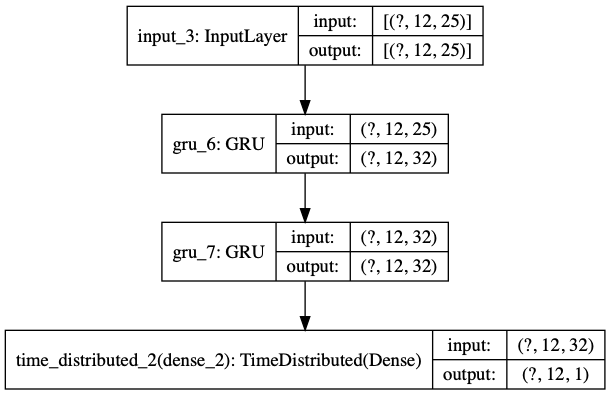

In [41]:
plot_model(model, 'model.png', show_shapes=True)

### Using above model + Categorical embedding

In [46]:
model.layers

In [48]:
model_cloned = tf.keras.models.clone_model(model)

In [49]:
model_cloned.set_weights(model.get_weights())

In [50]:
model_cloned.layers[-2].get_config()

{'name': 'gru_7',
 'trainable': True,
 'dtype': 'float32',
 'return_sequences': True,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'time_major': False,
 'units': 32,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'recurrent_initializer': {'class_name': 'Orthogonal',
  'config': {'gain': 1.0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'recurrent_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'recurrent_constraint': None,
 'bias_constraint': None,
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'implementation': 2,
 'reset_after': True}

In [53]:
for layer in model_cloned.layers[-2:-1]:
    print(layer)
    layer.return_sequences = False

In [55]:
model_cloned_2 = Model(inputs=model_cloned.input, outputs=model_cloned.layers[-2].output)
model_cloned_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12, 25)]          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 12, 32)            5664      
_________________________________________________________________
gru_7 (GRU)                  (None, 12, 32)            6336      
Total params: 12,000
Trainable params: 12,000
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_cloned_2.layers[-1].get_config()

{'name': 'gru_7',
 'trainable': True,
 'dtype': 'float32',
 'return_sequences': False,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'time_major': False,
 'units': 32,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'recurrent_initializer': {'class_name': 'Orthogonal',
  'config': {'gain': 1.0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'recurrent_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'recurrent_constraint': None,
 'bias_constraint': None,
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'implementation': 2,
 'reset_after': True}

In [66]:
for layer in model_cloned_2.layers:
    layer.trainable = False

In [16]:
categorical_features = [
    'shopid',
    'itemcategoryid',
    'shopcityid',
    'shoptypeid',
    'itemcategorytypeid',
    'itemcategorysubtypeid',
]

for feature in categorical_features:
    salesscaled[feature] = sales[feature].values
    encoder = LabelEncoder()
    salesscaled[feature] = encoder.fit_transform(salesscaled[feature])
    consecutive_categorical_ids(feature)

shopid
OK
itemcategoryid
OK
shopcityid
OK
shoptypeid
OK
itemcategorytypeid
OK
itemcategorysubtypeid
OK


In [73]:
inputs = Input(shape=(12,25))

grus = model_cloned_2(inputs)

shopidinputs = Input(shape=(1,))
shopidembedding = Embedding(
    output_dim=embedding_size(shopidnb),
    input_dim=shopidnb,
    input_length=1,
    embeddings_initializer='he_normal')(shopidinputs)#'uniform'
shopidembedding = Reshape((embedding_size(shopidnb),))(shopidembedding)

shoptypeidinputs = Input(shape=(1,))
shoptypeidembedding = Embedding(
    output_dim=embedding_size(shoptypeidnb),
    input_dim=shoptypeidnb,
    input_length=1,
    embeddings_initializer='he_normal')(shoptypeidinputs)
shoptypeidembedding = Reshape((embedding_size(shoptypeidnb),))(shoptypeidembedding)

shopcityididinputs = Input(shape=(1,))
shopcityidembedding = Embedding(
    output_dim=embedding_size(shopcityidnb),
    input_dim=shopcityidnb,
    input_length=1,
    embeddings_initializer='he_normal')(shopcityididinputs)
shopcityidembedding = Reshape((embedding_size(shopcityidnb),))(shopcityidembedding)

itemcategoryidinputs = Input(shape=(1,))
itemcategoryidembedding = Embedding(
    output_dim=embedding_size(itemcategoryidnb),
    input_dim=itemcategoryidnb,
    input_length=1,
    embeddings_initializer='he_normal')(itemcategoryidinputs)
itemcategoryidembedding = Reshape((embedding_size(itemcategoryidnb),))(itemcategoryidembedding)

itemcategorytypeidinputs = Input(shape=(1,))
itemcategorytypeidembedding = Embedding(
    output_dim=embedding_size(itemcategorytypeidnb),
    input_dim=itemcategorytypeidnb,
    input_length=1,
    embeddings_initializer='he_normal')(itemcategorytypeidinputs)
itemcategorytypeidembedding = Reshape((embedding_size(itemcategorytypeidnb),))(itemcategorytypeidembedding)

itemcategorysubtypeidinputs = Input(shape=(1,))
itemcategorysubtypeidembedding = Embedding(
    output_dim=embedding_size(itemcategorysubtypeidnb),
    input_dim=itemcategorysubtypeidnb,
    input_length=1,
    embeddings_initializer='he_normal')(itemcategorysubtypeidinputs)
itemcategorysubtypeidembedding = Reshape((embedding_size(itemcategorysubtypeidnb),))(itemcategorysubtypeidembedding)

concatenated_layer = Concatenate()([
    grus,
    shopidembedding,
    shoptypeidembedding,
    shopcityidembedding,
    itemcategoryidembedding,
    itemcategorytypeidembedding,
    itemcategorysubtypeidembedding
])

dense1 = Dense(64,activation='elu',kernel_initializer='he_normal')(concatenated_layer)

dense2 = Dense(64,activation='elu',kernel_initializer='he_normal')(dense1)

outs = Dense(1)(dense2)

model = Model(inputs=[
    inputs,
    shopidinputs,
    shoptypeidinputs,
    shopcityididinputs,
    itemcategoryidinputs,
    itemcategorytypeidinputs,
    itemcategorysubtypeidinputs
],outputs=outs)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])

In [69]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

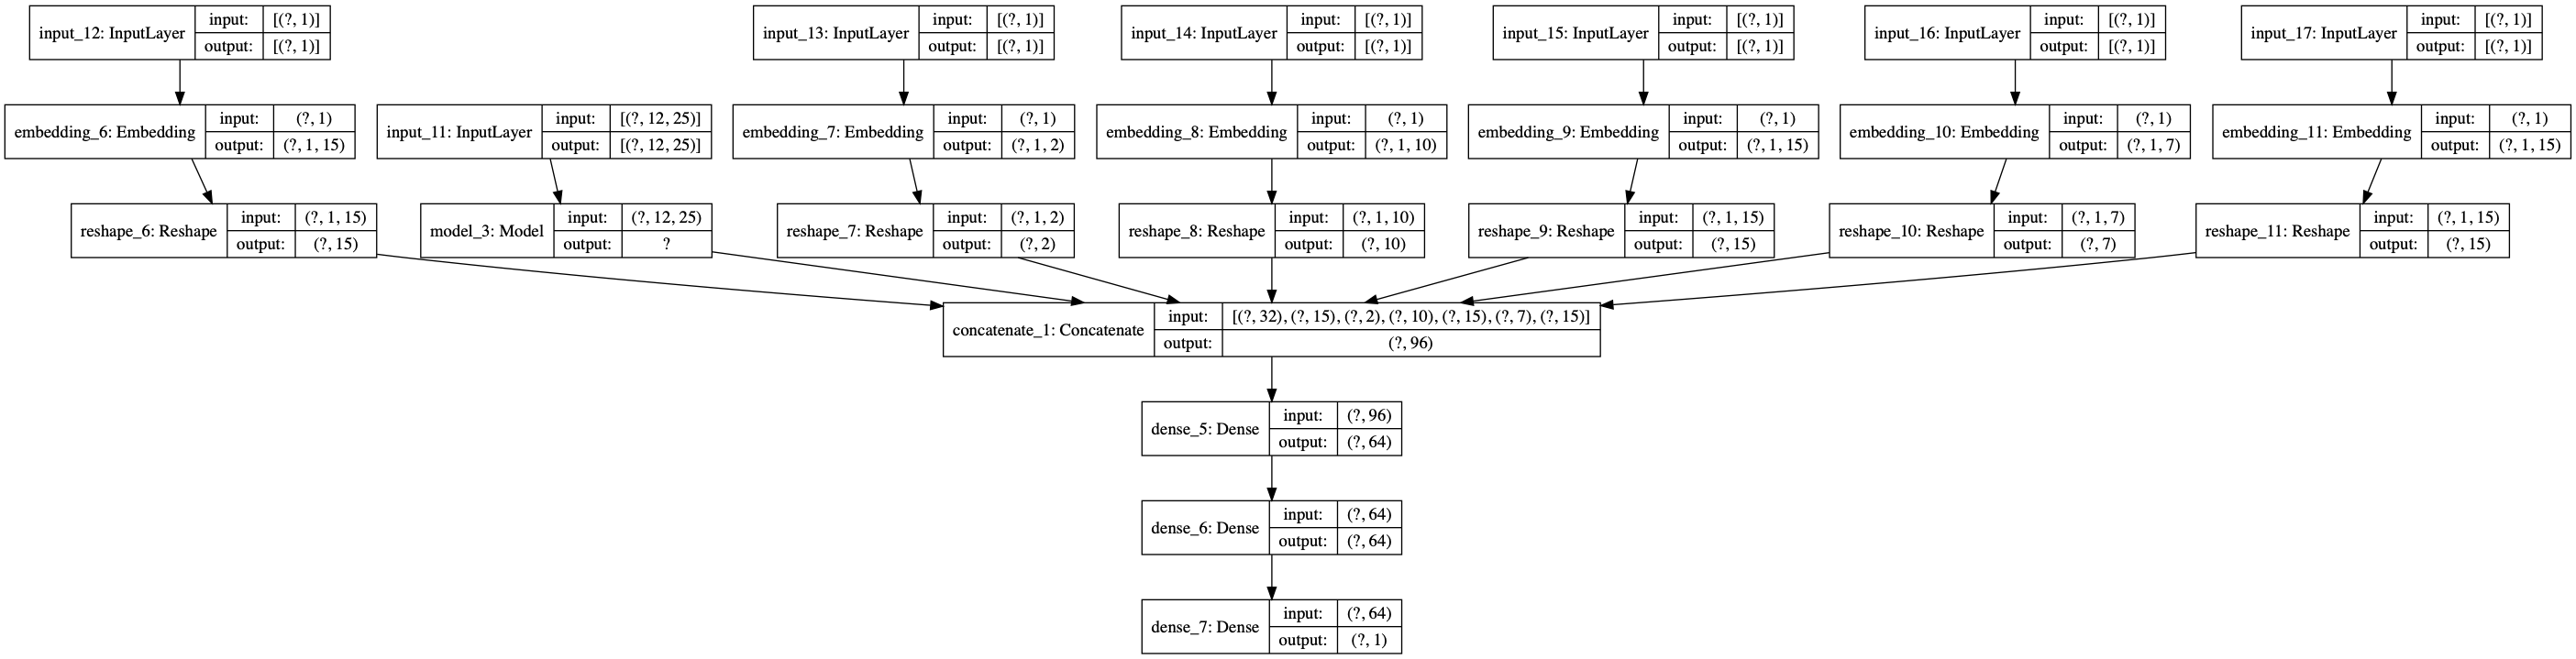

In [70]:
plot_model(model, 'model.png', show_shapes=True)

In [74]:
modelname = 'model_rnn_embedding.h5'
checkpoint_cb = ModelCheckpoint(modelname, save_best_only=True, monitor='val_last_time_step_mse')

monthpred = 33
train = salesscaled[salesscaled.monthoriginal<monthpred]
test = salesscaled[salesscaled.monthoriginal==monthpred]

epochs = 10
batchsize = 512

history = model.fit(
    [
        train[numerical_features].values.reshape(-1,12,25),
        train['shopid'].values.reshape(-1,1),
        train['shoptypeid'].values.reshape(-1,1),
        train['shopcityid'].values.reshape(-1,1),
        train['itemcategoryid'].values.reshape(-1,1),
        train['itemcategorytypeid'].values.reshape(-1,1),
        train['itemcategorysubtypeid'].values.reshape(-1,1)
    ],
    [train['target1'].values.reshape(-1,1)],
    epochs=epochs,verbose=1,batch_size=batchsize,callbacks=[checkpoint_cb],
    validation_data=(
        [
            test[numerical_features].values.reshape(-1,12,25),
            test['shopid'].values.reshape(-1,1),
            test['shoptypeid'].values.reshape(-1,1),
            test['shopcityid'].values.reshape(-1,1),
            test['itemcategoryid'].values.reshape(-1,1),
            test['itemcategorytypeid'].values.reshape(-1,1),
            test['itemcategorysubtypeid'].values.reshape(-1,1)
        ],
        [test['target1'].values.reshape(-1,1)]
    )
)

Train on 6186922 samples, validate on 238172 samples
Epoch 1/10
6186922/6186922 [==============================] - 1106s 179us/sample - loss: 0.6451 - last_time_step_mse: 0.6451 - val_loss: 0.8229 - val_last_time_step_mse: 0.8218
Epoch 2/10
6186922/6186922 [==============================] - 840s 136us/sample - loss: 0.6341 - last_time_step_mse: 0.6341 - val_loss: 0.8117 - val_last_time_step_mse: 0.8106
Epoch 3/10
6186922/6186922 [==============================] - 789s 128us/sample - loss: 0.6313 - last_time_step_mse: 0.6313 - val_loss: 0.8303 - val_last_time_step_mse: 0.8292
Epoch 4/10
6186922/6186922 [==============================] - 880s 142us/sample - loss: 0.6277 - last_time_step_mse: 0.6277 - val_loss: 0.8295 - val_last_time_step_mse: 0.8284
Epoch 5/10
6186922/6186922 [==============================] - 825s 133us/sample - loss: 0.6256 - last_time_step_mse: 0.6256 - val_loss: 0.8393 - val_last_time_step_mse: 0.8382
Epoch 6/10
6186922/6186922 [==============================] - 974s

In [75]:
modelname = 'model_rnn_embedding.h5'
dependencies = {
     'last_time_step_mse': last_time_step_mse
}
model = load_model(modelname,custom_objects=dependencies) #rollback to best model
mse = model.evaluate([
    test[numerical_features].values.reshape(-1,12,25),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1)
], [test['target1'].values.reshape(-1,1)])
print(mse)
rmse = math.sqrt(mse[1])
print('total rmse : {}'.format(rmse))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.8116770224567735, 0.81167287]
total rmse : 0.900928890836814


In [44]:
#This time, allowing the stack of GRU layers to be trained

In [80]:
for layer in model.layers[-11:-10]:
    print(layer)
    print(layer.trainable)
    print('')
    for layer2 in layer.layers:
        layer2.trainable = True
        print(layer2)
        print(layer2.trainable)

True

True
True
True


In [81]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)#learning rate divided by 2

model.compile(optimizer=optimizer, loss='mse', metrics=[last_time_step_mse])

In [82]:
modelname = 'model_rnn_trainable_embedding.h5'
checkpoint_cb = ModelCheckpoint(modelname, save_best_only=True, monitor='val_last_time_step_mse')

monthpred = 33
train = salesscaled[salesscaled.monthoriginal<monthpred]
test = salesscaled[salesscaled.monthoriginal==monthpred]

epochs = 10
batchsize = 512

history = model.fit(
    [
        train[numerical_features].values.reshape(-1,12,25),
        train['shopid'].values.reshape(-1,1),
        train['shoptypeid'].values.reshape(-1,1),
        train['shopcityid'].values.reshape(-1,1),
        train['itemcategoryid'].values.reshape(-1,1),
        train['itemcategorytypeid'].values.reshape(-1,1),
        train['itemcategorysubtypeid'].values.reshape(-1,1)
    ],
    [train['target1'].values.reshape(-1,1)],
    epochs=epochs,verbose=1,batch_size=batchsize,callbacks=[checkpoint_cb],
    validation_data=(
        [
            test[numerical_features].values.reshape(-1,12,25),
            test['shopid'].values.reshape(-1,1),
            test['shoptypeid'].values.reshape(-1,1),
            test['shopcityid'].values.reshape(-1,1),
            test['itemcategoryid'].values.reshape(-1,1),
            test['itemcategorytypeid'].values.reshape(-1,1),
            test['itemcategorysubtypeid'].values.reshape(-1,1)
        ],
        [test['target1'].values.reshape(-1,1)]
    )
)

Train on 6186922 samples, validate on 238172 samples
Epoch 1/10
6186922/6186922 [==============================] - 1085s 175us/sample - loss: 0.6453 - last_time_step_mse: 0.6453 - val_loss: 0.8595 - val_last_time_step_mse: 0.8583
Epoch 2/10
6186922/6186922 [==============================] - 839s 136us/sample - loss: 0.6383 - last_time_step_mse: 0.6383 - val_loss: 0.7925 - val_last_time_step_mse: 0.7915
Epoch 3/10
6186922/6186922 [==============================] - 844s 136us/sample - loss: 0.6403 - last_time_step_mse: 0.6403 - val_loss: 0.8639 - val_last_time_step_mse: 0.8627
Epoch 4/10
6186922/6186922 [==============================] - 1169s 189us/sample - loss: 0.6281 - last_time_step_mse: 0.6281 - val_loss: 0.8584 - val_last_time_step_mse: 0.8573
Epoch 5/10
6186922/6186922 [==============================] - 1053s 170us/sample - loss: 0.6256 - last_time_step_mse: 0.6256 - val_loss: 0.8415 - val_last_time_step_mse: 0.8404
Epoch 6/10
6186922/6186922 [==============================] - 82

In [35]:
modelname = 'model_rnn_trainable_embedding_0.8902.h5'
dependencies = {
     'last_time_step_mse': last_time_step_mse
}
model = load_model(modelname,custom_objects=dependencies) #rollback to best model
mse = model.evaluate([
    test[ts_features].values.reshape(-1,12,25),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1)
], [test['target1'].values.reshape(-1,1)])
print(mse)
rmse = math.sqrt(mse[1])
print('total rmse : {}'.format(rmse))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.7925675527610139, 0.7925648]
total rmse : 0.8902610905360051


In [36]:
#Submission using the best model so far

In [37]:
test = pd.read_csv('./data/test.csv')
test.columns = ['ID','shopid','itemid']
test.loc[test.shopid == 0, 'shopid'] = 57
test.loc[test.shopid == 1, 'shopid'] = 58
test.loc[test.shopid == 10, 'shopid'] = 11
test.head(1)

,ID,shopid,itemid
0,0,5,5037


In [40]:
testdf = salesscaled[salesscaled.monthoriginal == 34]
preds = model.predict([
    testdf[ts_features].values.reshape(-1,12,25),
    testdf['shopid'].values.reshape(-1,1),
    testdf['shoptypeid'].values.reshape(-1,1),
    testdf['shopcityid'].values.reshape(-1,1),
    testdf['itemcategoryid'].values.reshape(-1,1),
    testdf['itemcategorytypeid'].values.reshape(-1,1),
    testdf['itemcategorysubtypeid'].values.reshape(-1,1)
])
testdf['item_cnt_month'] = preds
submission = pd.merge(test,testdf[['shopidoriginal','itemidoriginal','item_cnt_month']],left_on=['shopid','itemid'],right_on=['shopidoriginal','itemidoriginal'],how='left')
submission = submission[['ID','item_cnt_month']]
print(submission.shape)
print(submission['item_cnt_month'].min())
print(submission['item_cnt_month'].max())
submission['item_cnt_month'] = submission['item_cnt_month'].clip(0,20)
print(submission['item_cnt_month'].min())
print(submission['item_cnt_month'].max())

submission.to_csv('submission.csv',index=False)

(214200, 2)
-1.1327147
21.001314
0.0
20.0


-> Public score 0.94477, not good compared to Lightgbm, the model doesn't generalize well

### Using the above model + Concatenating features selected for the Lgb model, and feeding everything into a MLP with 2 layers

In [17]:
numerical_features = [
    'month',
    'meanlagitemshop',
    'meanlagitem',
    'cumulativemeanitemshop',
    'nbdays',
    'year',
    'monthofyear',
    'nbweekends',
    'ratiolastanteprice',
    'ratiolastavgprice',
    'ratiolastminprice',
    'ratiolastmaxprice',
    'ratiorevenue12',
    'newitem',
    'tsshopid1',
    'tsshopid2',
    'tsshopid3',
    'tsshopid6',
    'tsshopid12',
    'tsshopcityid1',
    'tsshoptypeid1',
    'tsitemcategoryid1',
    'tsitemcategorysubtypeid1',
    'tsitemcategoryiditemcategorytypeid1',
    'tsitemcategoryiditemcategorysubtypeid1',
    'tsitemcategoryidshopcityid1',
    'tsitemcategoryidshoptypeid1',
    'tsitemcategoryidshopid1',
    'tsitemcategorytypeiditemcategorysubtypeid1',
    'tsitemcategorytypeidshopcityid1',
    'tsitemcategorytypeidshoptypeid1',
    'tsitemcategorytypeidshopid1',
    'tsitemcategorysubtypeidshopcityid1',
    'tsitemcategorysubtypeidshoptypeid1',
    'tsitemcategorysubtypeidshopid1',
    'tsshopcityidshoptypeid1',
    'tsshopcityidshopid1',
    'tsshoptypeidshopid1',
    'tsitemid1',
    'tsitemid2',
    'tsitemid3',
    'tsitemid6',
    'tsitemid12',
    'tsshopiditemid1',
    'tsshopiditemid2',
    'tsshopiditemid3',
    'tsshopiditemid6',
    'tsshopiditemid12'
]

In [18]:
scaler = StandardScaler()
scaler.fit(sales[numerical_features])

numarray = scaler.transform(sales[numerical_features])
numarray.shape

(6639294, 48)

In [19]:
for i in range(numarray.shape[1]):
    salesscaled[numerical_features[i]] = numarray[:,i]

In [20]:
with pd.option_context('display.max_rows', 200, 'display.max_columns', 200):
    display(salesscaled.head(2))

,tsitemid12,tsshopid12,tsshopcityid12,tsshoptypeid12,tsitemcategoryid12,tsitemcategorytypeid12,tsitemcategorysubtypeid12,tsshopiditemid12,tsitemcategoryiditemcategorytypeid12,tsitemcategoryiditemcategorysubtypeid12,tsitemcategoryidshopcityid12,tsitemcategoryidshoptypeid12,tsitemcategoryidshopid12,tsitemcategorytypeiditemcategorysubtypeid12,tsitemcategorytypeidshopcityid12,tsitemcategorytypeidshoptypeid12,tsitemcategorytypeidshopid12,tsitemcategorysubtypeidshopcityid12,tsitemcategorysubtypeidshoptypeid12,tsitemcategorysubtypeidshopid12,tsshopcityidshoptypeid12,tsshopcityidshopid12,tsshoptypeidshopid12,tstarget12,tsrevenue12,tsitemid11,tsshopid11,tsshopcityid11,tsshoptypeid11,tsitemcategoryid11,tsitemcategorytypeid11,tsitemcategorysubtypeid11,tsshopiditemid11,tsitemcategoryiditemcategorytypeid11,tsitemcategoryiditemcategorysubtypeid11,tsitemcategoryidshopcityid11,tsitemcategoryidshoptypeid11,tsitemcategoryidshopid11,tsitemcategorytypeiditemcategorysubtypeid11,tsitemcategorytypeidshopcityid11,tsitemcategorytypeidshoptypeid11,tsitemcategorytypeidshopid11,tsitemcategorysubtypeidshopcityid11,tsitemcategorysubtypeidshoptypeid11,tsitemcategorysubtypeidshopid11,tsshopcityidshoptypeid11,tsshopcityidshopid11,tsshoptypeidshopid11,tstarget11,tsrevenue11,tsitemid10,tsshopid10,tsshopcityid10,tsshoptypeid10,tsitemcategoryid10,tsitemcategorytypeid10,tsitemcategorysubtypeid10,tsshopiditemid10,tsitemcategoryiditemcategorytypeid10,tsitemcategoryiditemcategorysubtypeid10,tsitemcategoryidshopcityid10,tsitemcategoryidshoptypeid10,tsitemcategoryidshopid10,tsitemcategorytypeiditemcategorysubtypeid10,tsitemcategorytypeidshopcityid10,tsitemcategorytypeidshoptypeid10,tsitemcategorytypeidshopid10,tsitemcategorysubtypeidshopcityid10,tsitemcategorysubtypeidshoptypeid10,tsitemcategorysubtypeidshopid10,tsshopcityidshoptypeid10,tsshopcityidshopid10,tsshoptypeidshopid10,tstarget10,tsrevenue10,tsitemid9,tsshopid9,tsshopcityid9,tsshoptypeid9,tsitemcategoryid9,tsitemcategorytypeid9,tsitemcategorysubtypeid9,tsshopiditemid9,tsitemcategoryiditemcategorytypeid9,tsitemcategoryiditemcategorysubtypeid9,tsitemcategoryidshopcityid9,tsitemcategoryidshoptypeid9,tsitemcategoryidshopid9,tsitemcategorytypeiditemcategorysubtypeid9,tsitemcategorytypeidshopcityid9,tsitemcategorytypeidshoptypeid9,tsitemcategorytypeidshopid9,tsitemcategorysubtypeidshopcityid9,tsitemcategorysubtypeidshoptypeid9,tsitemcategorysubtypeidshopid9,tsshopcityidshoptypeid9,tsshopcityidshopid9,tsshoptypeidshopid9,tstarget9,tsrevenue9,...,tsitemcategoryidshopcityid3,tsitemcategoryidshoptypeid3,tsitemcategoryidshopid3,tsitemcategorytypeiditemcategorysubtypeid3,tsitemcategorytypeidshopcityid3,tsitemcategorytypeidshoptypeid3,tsitemcategorytypeidshopid3,tsitemcategorysubtypeidshopcityid3,tsitemcategorysubtypeidshoptypeid3,tsitemcategorysubtypeidshopid3,tsshopcityidshoptypeid3,tsshopcityidshopid3,tsshoptypeidshopid3,tstarget3,tsrevenue3,tsitemid2,tsshopid2,tsshopcityid2,tsshoptypeid2,tsitemcategoryid2,tsitemcategorytypeid2,tsitemcategorysubtypeid2,tsshopiditemid2,tsitemcategoryiditemcategorytypeid2,tsitemcategoryiditemcategorysubtypeid2,tsitemcategoryidshopcityid2,tsitemcategoryidshoptypeid2,tsitemcategoryidshopid2,tsitemcategorytypeiditemcategorysubtypeid2,tsitemcategorytypeidshopcityid2,tsitemcategorytypeidshoptypeid2,tsitemcategorytypeidshopid2,tsitemcategorysubtypeidshopcityid2,tsitemcategorysubtypeidshoptypeid2,tsitemcategorysubtypeidshopid2,tsshopcityidshoptypeid2,tsshopcityidshopid2,tsshoptypeidshopid2,tstarget2,tsrevenue2,tsitemid1,tsshopid1,tsshopcityid1,tsshoptypeid1,tsitemcategoryid1,tsitemcategorytypeid1,tsitemcategorysubtypeid1,tsshopiditemid1,tsitemcategoryiditemcategorytypeid1,tsitemcategoryiditemcategorysubtypeid1,tsitemcategoryidshopcityid1,tsitemcategoryidshoptypeid1,tsitemcategoryidshopid1,tsitemcategorytypeiditemcategorysubtypeid1,tsitemcategorytypeidshopcityid1,tsitemcategorytypeidshoptypeid1,tsitemcategorytypeidshopid1,tsitemcategorysubtypeidshopcityid1,tsitemcategorysubtypeidshoptypeid1,tsite

In [25]:
monthpred = 33
test = salesscaled[salesscaled.monthoriginal==monthpred]

modelname = 'model_rnn_trainable_embedding_0.8902.h5'
dependencies = {
     'last_time_step_mse': last_time_step_mse
}
model = load_model(modelname,custom_objects=dependencies) #rollback to best model
mse = model.evaluate([
    test[ts_features].values.reshape(-1,12,25),
    test['shopid'].values.reshape(-1,1),
    test['shoptypeid'].values.reshape(-1,1),
    test['shopcityid'].values.reshape(-1,1),
    test['itemcategoryid'].values.reshape(-1,1),
    test['itemcategorytypeid'].values.reshape(-1,1),
    test['itemcategorysubtypeid'].values.reshape(-1,1)
], [test['target1'].values.reshape(-1,1)])
print(mse)
rmse = math.sqrt(mse[1])
print('total rmse : {}'.format(rmse))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.7925675527610139, 0.7925648]
total rmse : 0.8902610905360051


In [26]:
model.layers

In [27]:
for layer in model.layers:
    layer.trainable = False

In [28]:
for layer in model.layers[-11:-10]:
    print(layer)
    print(layer.trainable)
    for layer2 in layer.layers:
        print(layer2)
        print(layer2.trainable)

False
False
False
False


In [29]:
numericalinputs = Input(shape=(len(numerical_features),))

concatenated_layer = Concatenate()([
    model.layers[-4].output,
    numericalinputs
])

dense1 = Dense(128,activation='elu',kernel_initializer='he_normal')(concatenated_layer)

dense2 = Dense(64,activation='elu',kernel_initializer='he_normal')(dense1)

outs = Dense(1)(dense2)

model = Model(inputs=[
    model.inputs,
    numericalinputs
],outputs=outs)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='mse')

In [ ]:
model.summary()

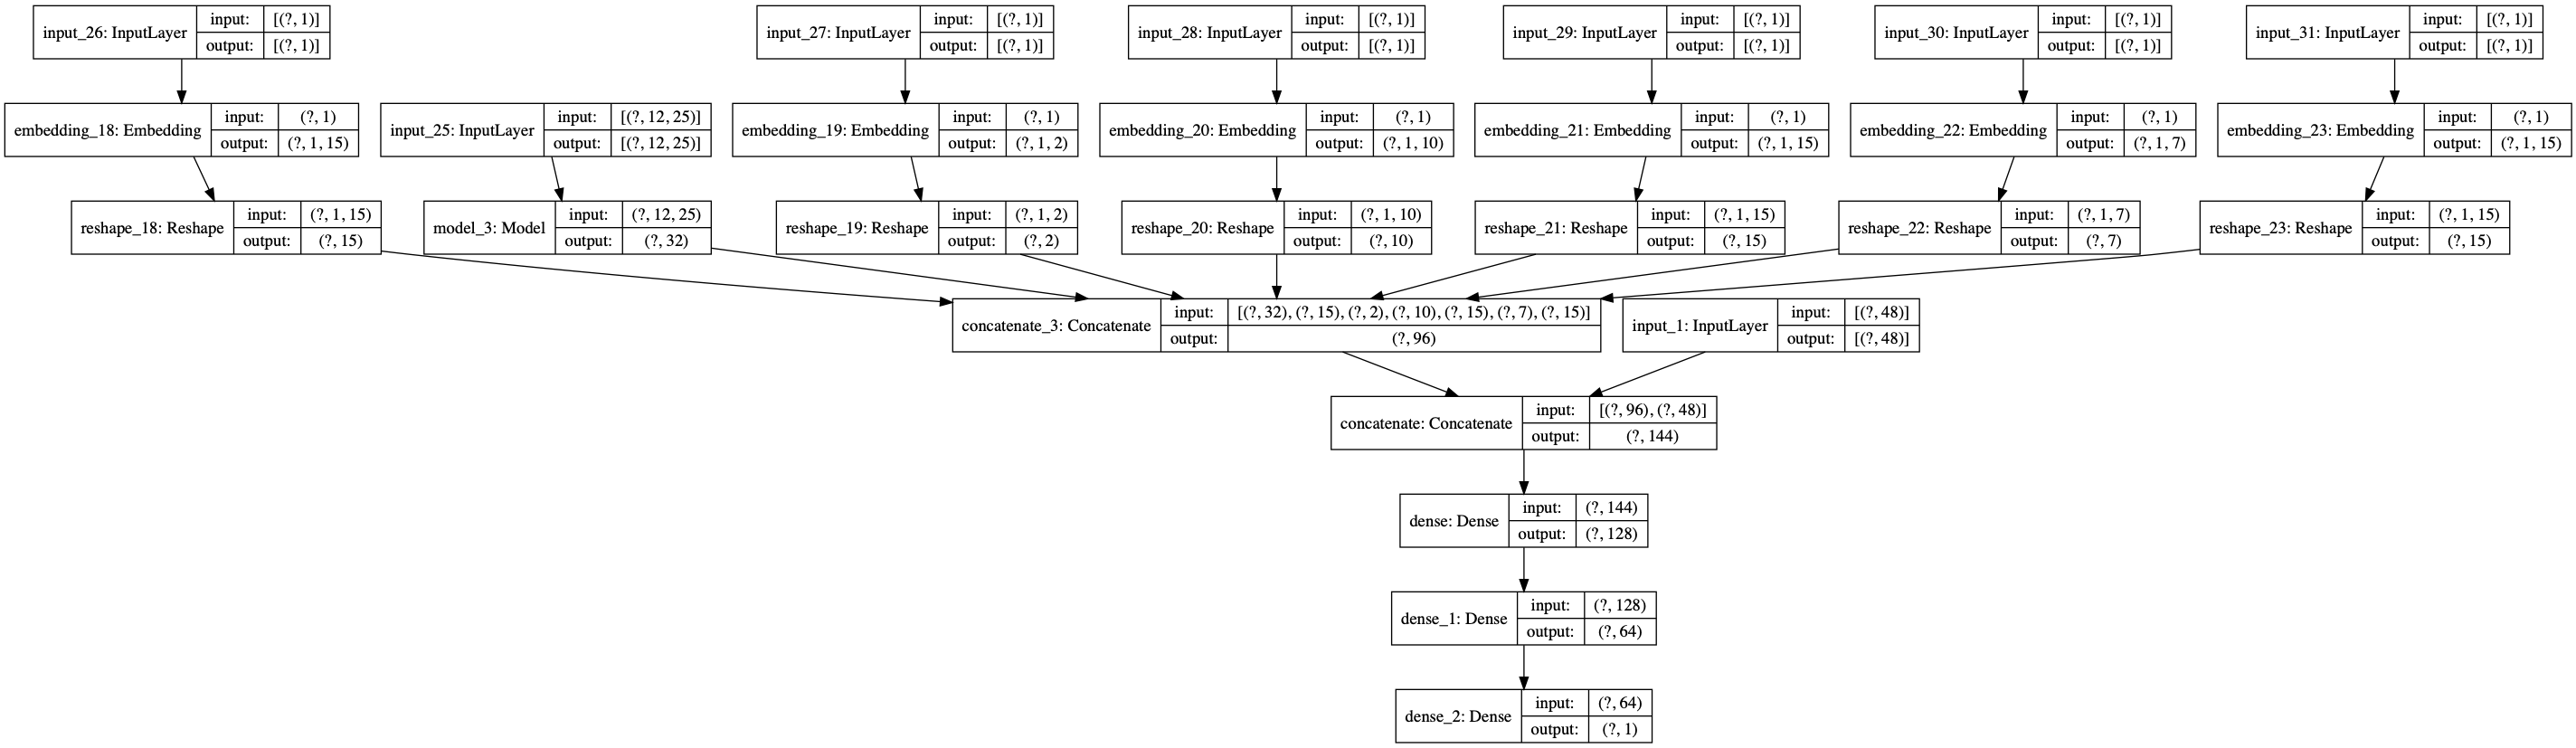

In [31]:
plot_model(model, 'model.png', show_shapes=True)

In [32]:
modelname = 'model_rnn_embedding_numerical.h5'
checkpoint_cb = ModelCheckpoint(modelname, save_best_only=True, monitor='val_loss')

monthpred = 33
train = salesscaled[salesscaled.monthoriginal<monthpred]
test = salesscaled[salesscaled.monthoriginal==monthpred]

epochs = 10
batchsize = 512

history = model.fit(
    [
        train[ts_features].values.reshape(-1,12,25),
        train['shopid'].values.reshape(-1,1),
        train['shoptypeid'].values.reshape(-1,1),
        train['shopcityid'].values.reshape(-1,1),
        train['itemcategoryid'].values.reshape(-1,1),
        train['itemcategorytypeid'].values.reshape(-1,1),
        train['itemcategorysubtypeid'].values.reshape(-1,1),
        train[numerical_features].values.reshape(-1,48)
    ],
    [train['target1'].values.reshape(-1,1)],
    epochs=epochs,verbose=1,batch_size=batchsize,callbacks=[checkpoint_cb],
    validation_data=(
        [
            test[ts_features].values.reshape(-1,12,25),
            test['shopid'].values.reshape(-1,1),
            test['shoptypeid'].values.reshape(-1,1),
            test['shopcityid'].values.reshape(-1,1),
            test['itemcategoryid'].values.reshape(-1,1),
            test['itemcategorytypeid'].values.reshape(-1,1),
            test['itemcategorysubtypeid'].values.reshape(-1,1),
            test[numerical_features].values.reshape(-1,48)
        ],
        [test['target1'].values.reshape(-1,1)]
    )
)

Train on 6186922 samples, validate on 238172 samples
Epoch 1/10
6186922/6186922 [==============================] - 7674s 1ms/sample - loss: 0.6320 - val_loss: 0.9706
Epoch 2/10
6186922/6186922 [==============================] - 8211s 1ms/sample - loss: 0.6088 - val_loss: 0.9086
Epoch 3/10
6186922/6186922 [==============================] - 7819s 1ms/sample - loss: 0.6014 - val_loss: 0.8762
Epoch 4/10
6186922/6186922 [==============================] - 7725s 1ms/sample - loss: 0.5962 - val_loss: 0.8404
Epoch 5/10
6186922/6186922 [==============================] - 7507s 1ms/sample - loss: 0.5918 - val_loss: 0.8757
Epoch 6/10
6186922/6186922 [==============================] - 7402s 1ms/sample - loss: 0.5885 - val_loss: 0.9540
Epoch 7/10
6186922/6186922 [==============================] - 7267s 1ms/sample - loss: 0.5857 - val_loss: 0.8922
Epoch 8/10
6186922/6186922 [==============================] - 7424s 1ms/sample - loss: 0.5833 - val_loss: 0.8794
Epoch 9/10
6186922/6186922 [===============

W0404 15:12:31.594693 4449074624 callbacks.py:989] Can save best model only with val_loss available, skipping.


3164672/6186922 [==============>...............] - ETA: 1:04:02 - loss: 0.5772

KeyboardInterrupt: 

-> Clearly overfits.  
Very time consuming to pursue tests using deep learning with my Macbook pro 13"